In [38]:
#change directory
import os
os.chdir('/Users/kaixianglim/Documents/DSS5104/Group_Project/5-min_frequency_data/FINAL')

import numpy as np 
import pylab as plt
import pandas as pd
import sklearn
from scipy.stats import zscore
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder


## ENERGY PRICE DATA

In [39]:
# load file 'Energy_Data/df_with_lag_indicators.csv.gz' into a pandas dataframe
df = pd.read_csv('Energy_Data/df_with_lag_indicators.csv.gz', compression='gzip')


In [40]:
#df header
df.head()

,timestamp,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure,hour,dayofweek,month,lag_1,lag_12,lag_288,lag_576,rolling_mean_24,rolling_std_24
0,3/1/22 0:00,7294.03,4.370966,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,3/1/22 0:05,7304.76,4.507557,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.370966,NaN,NaN,NaN,NaN,NaN
2,3/1/22 0:10,7176.53,4.476996,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.507557,NaN,NaN,NaN,NaN,NaN
3,3/1/22 0:15,7247.72,4.497028,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.476996,NaN,NaN,NaN,NaN,NaN
4,3/1/22 0:20,7169.96,4.478132,78.25,3.74,0.0,313.43,58.81,22,0,0,0,1,4.497028,NaN,NaN,NaN,NaN,NaN


In [41]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [42]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

In [43]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [44]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 0.2156
Mean Squared Error on the Test Set: 0.2025
Root Mean Squared Error on the Test Set: 0.4500
R^2 Score: 0.7138
Adjusted R^2 Score: 0.7137


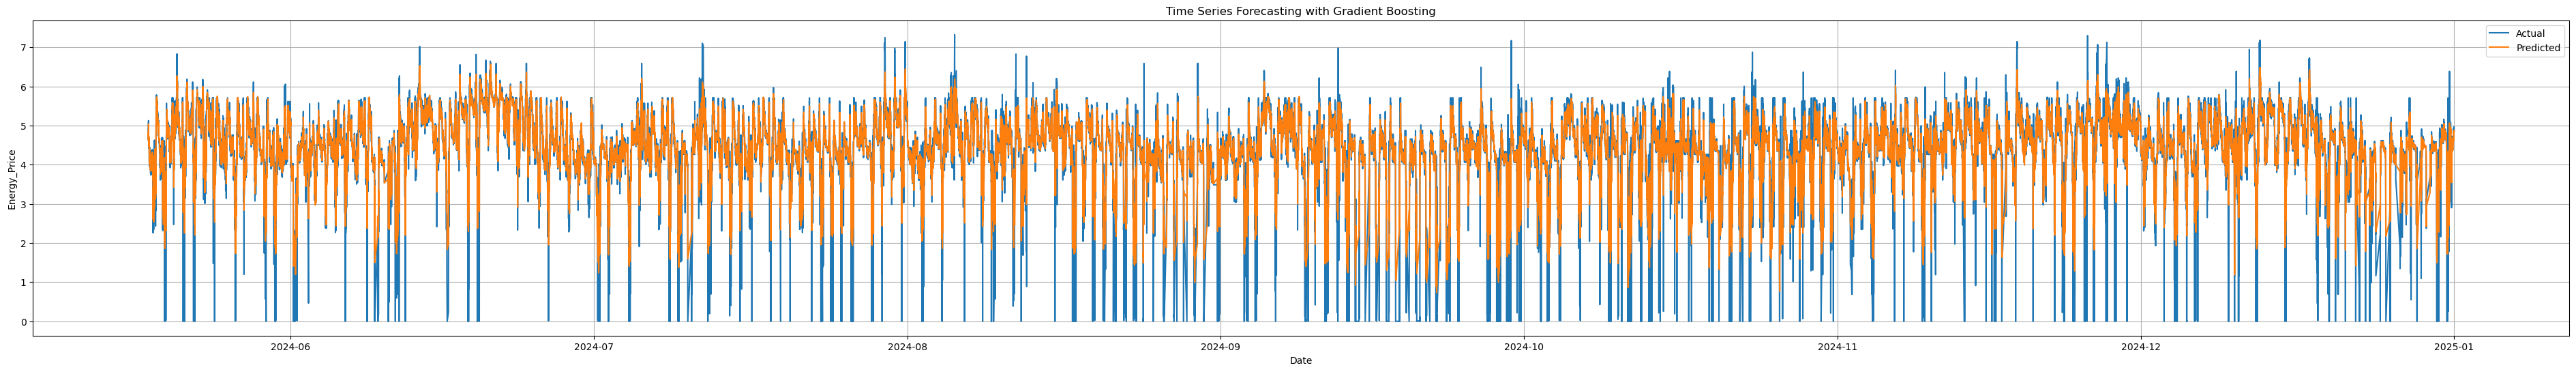

In [45]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_1: 0.4319
rolling_mean_24: 0.3256
lag_288: 0.0542
lag_12: 0.0386
Energy_Demand: 0.0306
rolling_std_24: 0.0283
hour: 0.0206
lag_576: 0.0137
Crude_Oil_Price: 0.0114
Solar_Exposure: 0.0079
Temperature: 0.0074
Natural_Gas_Price: 0.0071
Carbon_Intensity: 0.0065
Renewable_Energy_Percentage: 0.0050
month: 0.0042
dayofweek: 0.0036
Rainfall: 0.0034


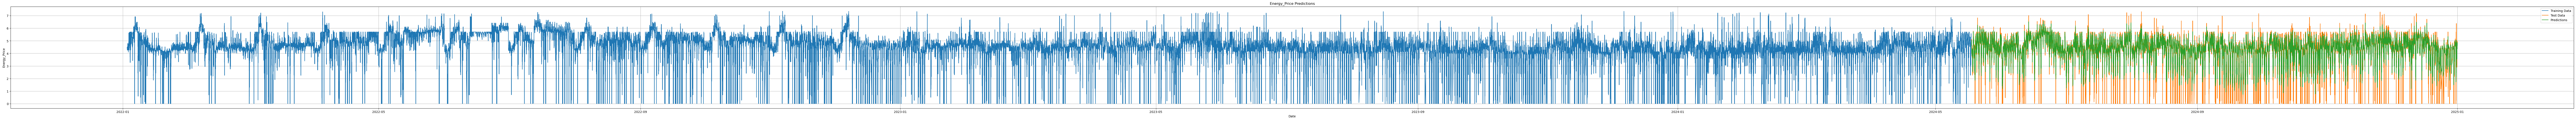

In [47]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## FINANCE DATA

In [48]:
# load file 'Finance_Data/processed_finance_data.csv' into a pandas dataframe
df = pd.read_csv('Finance_Data/processed_finance_data.csv')

In [49]:
#df header
df.head()

,Date,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_day,TSLA_month,TSLA_weekday,day_sin,day_cos,month_sin,...,Close_SOXX,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University_of_Michigan-Consumer_Sentiment,Consumer_Price_Index-All_Items-Total_for_United_States,Total_Vehicle_Sales
0,2014-09-17,17.425333,77665500.0,0.002454,17.0,9.0,2.0,-0.299363,-0.954139,-1.0,...,26.093210,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959
1,2014-09-18,17.587999,55389000.0,0.009335,18.0,9.0,3.0,-0.485302,-0.874347,-1.0,...,26.492056,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959
2,2014-09-19,17.288000,102163500.0,-0.017057,19.0,9.0,4.0,-0.651372,-0.758758,-1.0,...,26.161163,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959
3,2014-09-22,16.668667,123211500.0,-0.035824,22.0,9.0,0.0,-0.968077,-0.250653,-1.0,...,25.845039,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959
4,2014-09-23,16.694000,84880500.0,0.001520,23.0,9.0,1.0,-0.998717,-0.050649,-1.0,...,25.762320,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959


In [50]:
df_target = 'Close_TSLA'
df_predictors = [col for col in df.columns if col != df_target]

In [51]:
#set timestamp as index
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)

In [52]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [53]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 6.9729
Mean Squared Error on the Test Set: 106.3427
Root Mean Squared Error on the Test Set: 10.3123
R^2 Score: 0.9519
Adjusted R^2 Score: 0.9418


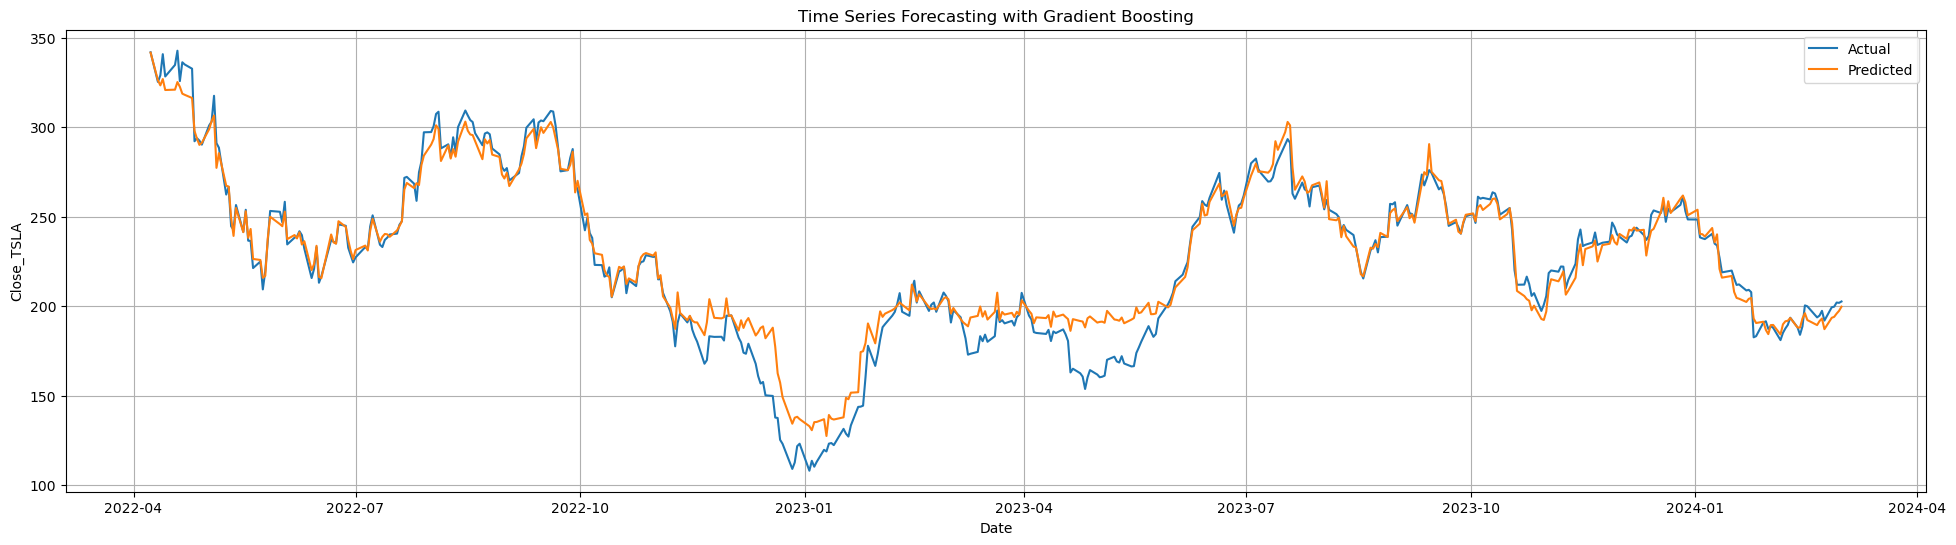

In [54]:
# 7. Visualize the Results
plt.figure(figsize=(24, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Close_%5EGSPC: 0.3278
Close_LIT: 0.3144
Close_TSLA_Lag_5: 0.1179
Close_TSLA_Lag_1: 0.1158
TSLA_Ichimoku_Base_Line: 0.0279
Close_TSLA_Lag_30: 0.0167
TSLA_EMA_20: 0.0127
TSLA_Ichimoku_Conversion_Line: 0.0124
Close_TSLA_Lag_3: 0.0071
Close_BZ=F: 0.0060
TSLA_Total_Return_252d: 0.0058
TSLA_BB_High: 0.0054
PCE_Price_Index: 0.0054
TSLA_Open_SMA_10: 0.0049
TSLA_EMA_40: 0.0035
Close_TSLA_Lag_120: 0.0030
Close_TSLA_Lag_4: 0.0024
TSLA_Open_EMA_10: 0.0020
TSLA_SMA_200: 0.0014
TSLA_VWAP_Open: 0.0011
month_sin: 0.0011
Close_TSLA_Lag_2: 0.0009
TSLA_Total_Return_120d: 0.0008
Close_TSLA_Lag_20: 0.0008
Close_SOXX: 0.0005
TSLA_Total_Return_90d: 0.0005
TSLA_month: 0.0003
Close_TSLA_Lag_10: 0.0002
TSLA_Total_Return_10d: 0.0002
Close_BTC-USD: 0.0001
TSLA_Ichimoku_Leading_Span_A: 0.0001
TSLA_Daily_Return: 0.0001
Close_TSLA_Lag_90: 0.0001
TSLA_Returns: 0.0001
TSLA_Ichimoku_Lagging_Span: 0.0001
TSLA_Open_Return: 0.0001
TSLA_Total_Return_5d: 0.0000
TSLA_RSI: 0.0000
TSLA_SMA_100: 0.0000
TSLA_SMA_150: 0.0000
TSLA

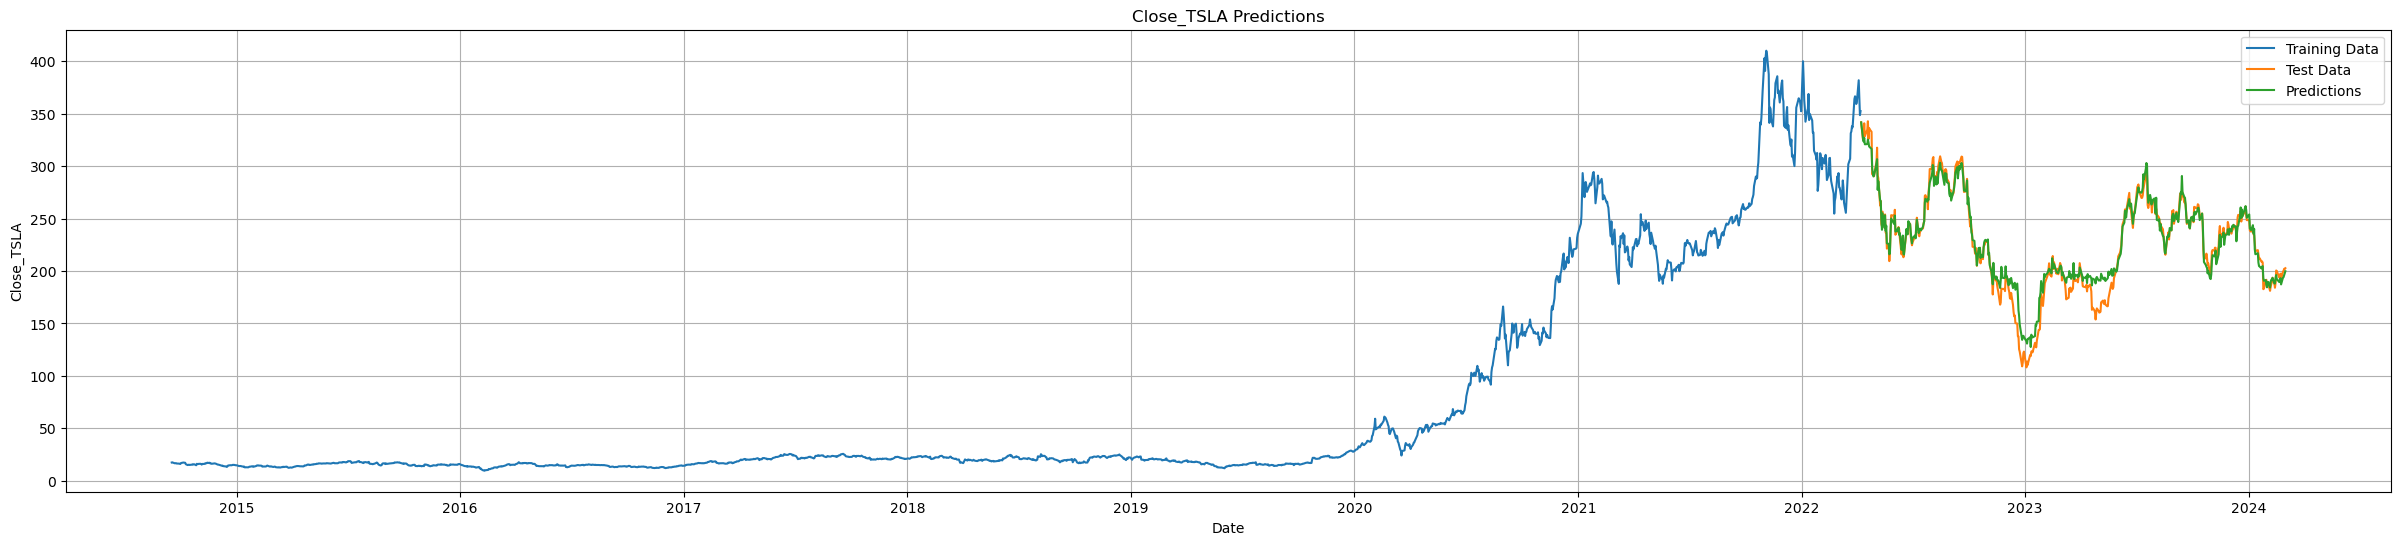

In [56]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(30, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## CLIMATE DATA

In [57]:
# load file 'Climate_Data/Temperature-Data-with-Lag-Features-of-California.csv into a pandas dataframe
df = pd.read_csv('Climate_Data/Temperature-Data-with-Lag-Features-of-California.csv')


In [58]:
#df header
df.head()

,TIME,Mean_Temperature,lag_1,lag_12
0,1/1/81,0.152648,NaN,NaN
1,1/2/81,2.161510,0.152648,NaN
2,1/3/81,5.807921,2.161510,NaN
3,1/4/81,12.537520,5.807921,NaN
4,1/5/81,14.826269,12.537520,NaN


In [59]:
df_target = 'Mean_Temperature'
df_predictors = [col for col in df.columns if col != df_target]

In [60]:
#set timestamp as index
df['TIME'] = pd.to_datetime(df['TIME'], format='%d/%m/%y')
df.set_index('TIME', inplace=True)

In [61]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [62]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 1.1736
Mean Squared Error on the Test Set: 2.4354
Root Mean Squared Error on the Test Set: 1.5606
R^2 Score: 0.9664
Adjusted R^2 Score: 0.9657


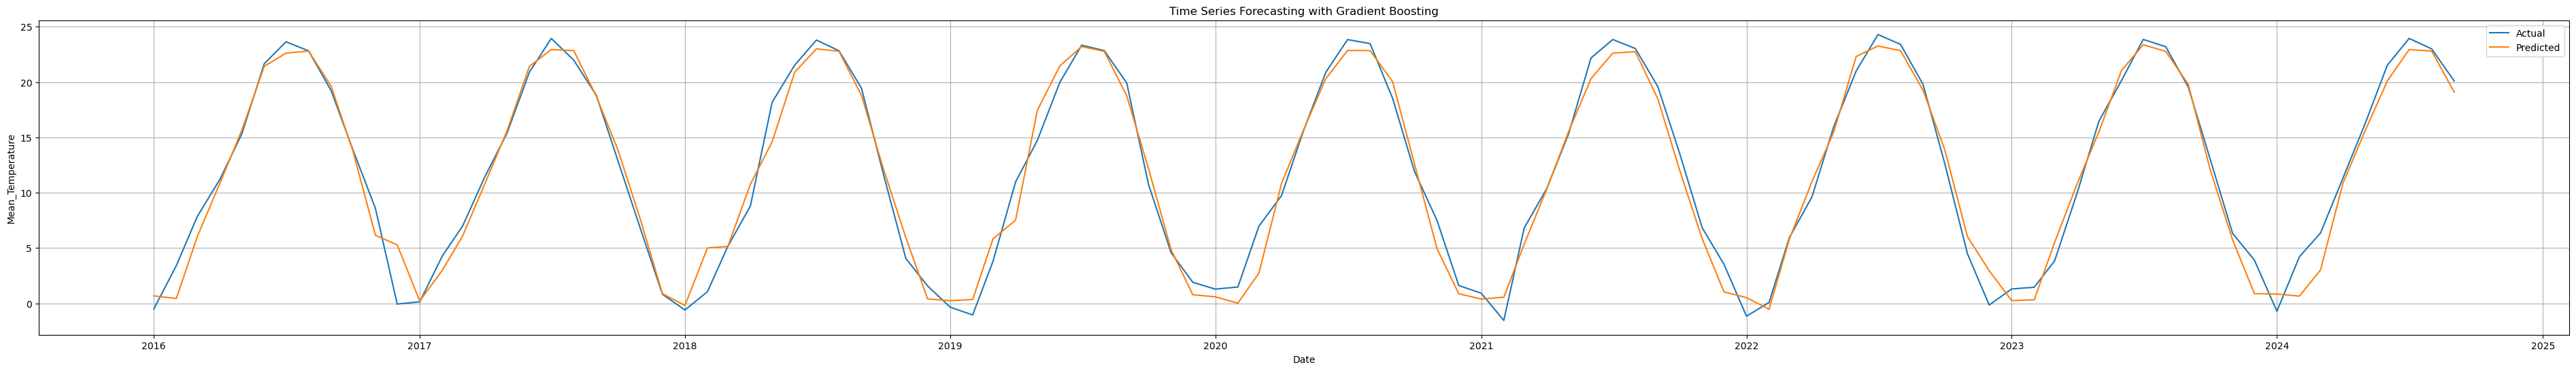

In [63]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

lag_12: 0.9600
lag_1: 0.0400


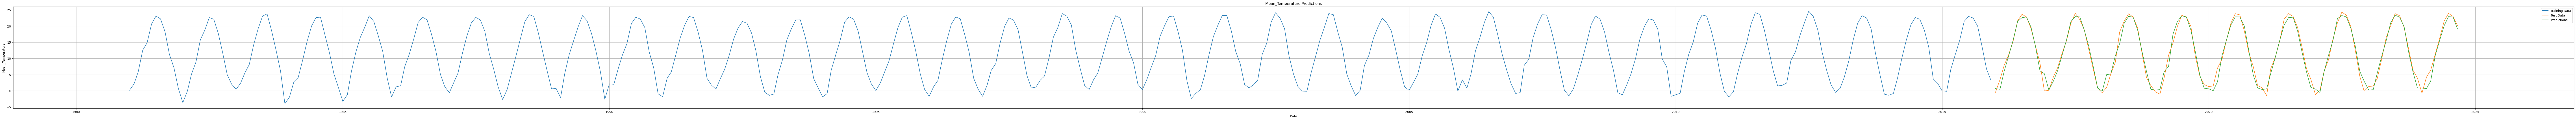

In [65]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## RETAIL DATA

In [66]:
# load file 'Retail_Data/data_with_lags_s1_i1.parquet' into a pandas dataframe
df = pd.read_parquet('Retail_Data/data_with_lags_s1_i1.parquet')


In [67]:
#df header
df.head()

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,sales_roll_std_60d,sales_roll_median_60d,sales_roll_min_60d,sales_roll_max_60d,sales_roll_mean_90d,sales_roll_std_90d,sales_roll_median_90d,sales_roll_min_90d,sales_roll_max_90d,split
0,2014-01-01,9,2014,1,1,2,1,1,1,1,...,5.645732,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0,train
1,2014-01-02,14,2014,1,2,3,2,1,1,0,...,5.628820,16.0,5.0,31.0,15.733333,5.120569,16.0,5.0,31.0,train
2,2014-01-03,11,2014,1,3,4,3,1,1,0,...,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0,train
3,2014-01-04,20,2014,1,4,5,4,1,1,0,...,5.640326,16.0,5.0,31.0,15.700000,5.141700,16.0,5.0,31.0,train
4,2014-01-05,17,2014,1,5,6,5,1,1,0,...,5.643856,16.0,5.0,31.0,15.744444,5.135383,16.0,5.0,31.0,train


In [68]:
df_target = 'sales'
df_predictors = [col for col in df.columns if col != df_target]

In [70]:
#set timestamp as index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

In [73]:
#unique values in the 'split' column
df['split'].unique()

array(['train', 'validation'], dtype=object)

In [74]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage

train_df = df[df["split"] == "train"]
test_df = df[df["split"] == "validation"]

X_train = train_df.drop(columns=[df_target, "split"])
y_train = train_df[df_target]

X_test = test_df.drop(columns=[df_target, "split"])
y_test = test_df[df_target]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [75]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 3.3060
Mean Squared Error on the Test Set: 15.1828
Root Mean Squared Error on the Test Set: 3.8965
R^2 Score: 0.5523
Adjusted R^2 Score: 0.1144


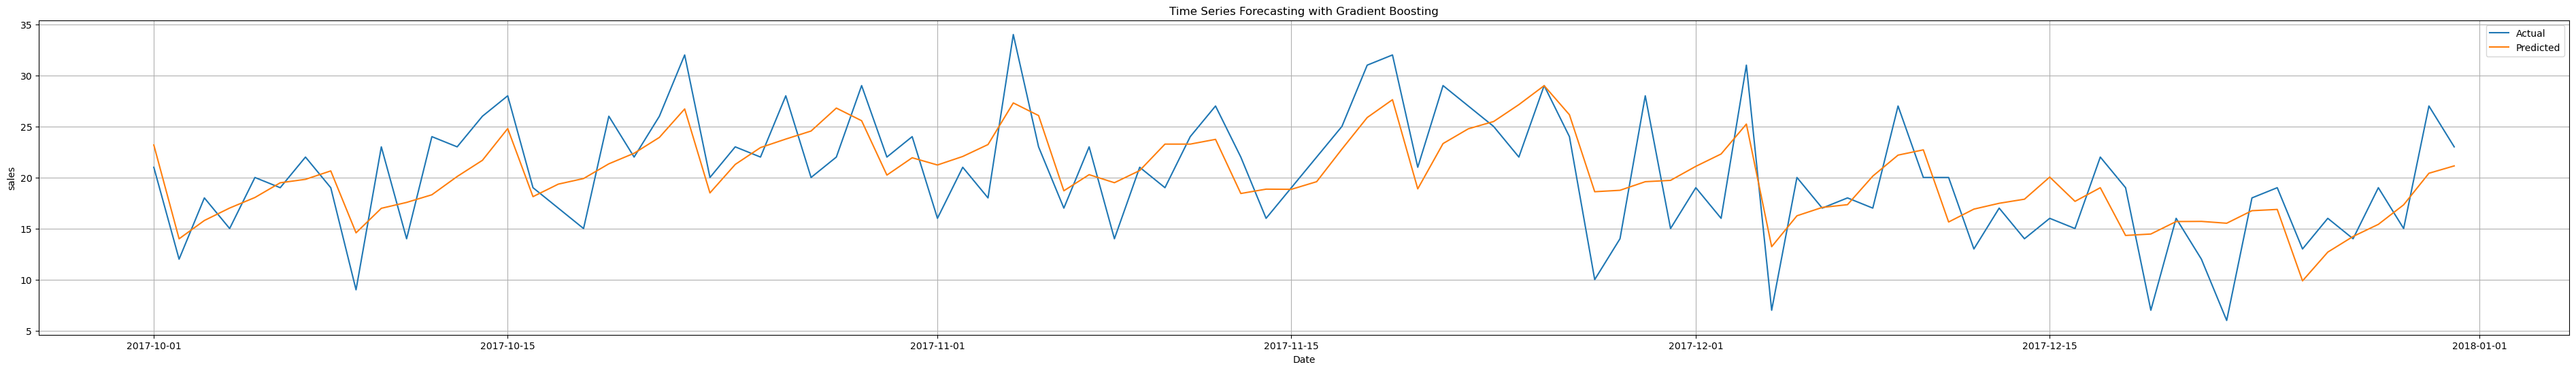

In [77]:
# 7. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

sales_roll_median_28d: 0.4536
sales_roll_mean_7d: 0.1086
sales_roll_mean_14d: 0.1029
dayofweek: 0.0440
sales_lag_364: 0.0314
sales_lag_14: 0.0257
sales_roll_median_7d: 0.0243
sales_roll_max_7d: 0.0180
sales_roll_std_7d: 0.0154
sales_roll_min_7d: 0.0149
sales_lag_21: 0.0121
sales_lag_365: 0.0097
month: 0.0088
sales_roll_min_14d: 0.0083
dayofyear: 0.0076
sales_roll_median_14d: 0.0075
sales_roll_std_90d: 0.0073
sales_lag_1: 0.0069
sales_lag_7: 0.0068
sales_roll_mean_60d: 0.0066
sales_roll_std_14d: 0.0063
sales_roll_min_28d: 0.0062
weekofyear: 0.0060
sales_lag_180: 0.0059
sales_roll_max_90d: 0.0058
sales_roll_std_60d: 0.0055
sales_roll_mean_90d: 0.0054
quarter: 0.0052
sales_roll_mean_28d: 0.0050
sales_roll_std_28d: 0.0045
sales_lag_90: 0.0045
sales_lag_28: 0.0044
sales_lag_60: 0.0043
sales_roll_max_14d: 0.0035
sales_roll_min_60d: 0.0034
day: 0.0024
sales_lag_30: 0.0016
year: 0.0000
is_month_start: 0.0000
is_month_end: 0.0000
sales_roll_max_28d: 0.0000
sales_roll_median_60d: 0.0000
sales_ro

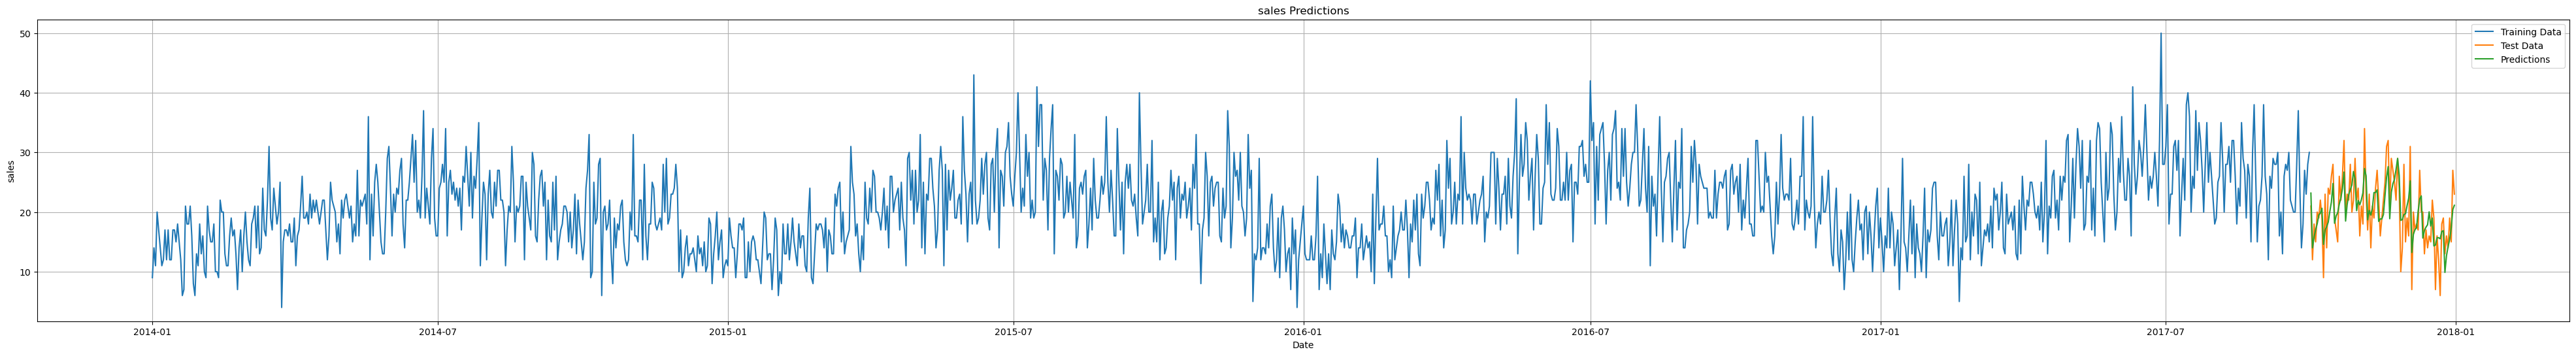

In [83]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(50, 6))
plt.plot(X_train.index, y_train, label='Training Data')
plt.plot(X_test.index, y_test, label='Test Data')
plt.plot(X_test.index, predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

## TRANSPORT DATA

In [84]:
# load file 'Transport_Data/Baltimore_Lagged_Dataset.csv' into a pandas dataframe
df = pd.read_csv('Transport_Data/Baltimore_Lagged_Dataset.csv')


In [85]:
#df header
df.head()

,Month,Total TEUs,Lag_1,Lag_2,Lag_3,Lag_6,Lag_12
0,1/1/99,38642,41957,43415,37762,41293,38104
1,2/1/99,39418,38642,41957,43415,36461,38175
2,3/1/99,45703,39418,38642,41957,41678,46578
3,4/1/99,40671,45703,39418,38642,37762,41703
4,5/1/99,39035,40671,45703,39418,43415,40908


In [88]:
df_target = 'Total TEUs'
df_predictors = [col for col in df.columns if col != df_target]

In [86]:
#set timestamp as index
df['Month'] = pd.to_datetime(df['Month'], format='%m/%d/%y')
df.set_index('Month', inplace=True)

In [89]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 4. Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=1,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 5. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [90]:
# 6. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Absolute Error on the Test Set: {mae:.4f}")
print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

Mean Absolute Error on the Test Set: 10674.8814
Mean Squared Error on the Test Set: 274188797.6521
Root Mean Squared Error on the Test Set: 16558.6472
R^2 Score: 0.2479
Adjusted R^2 Score: 0.1819


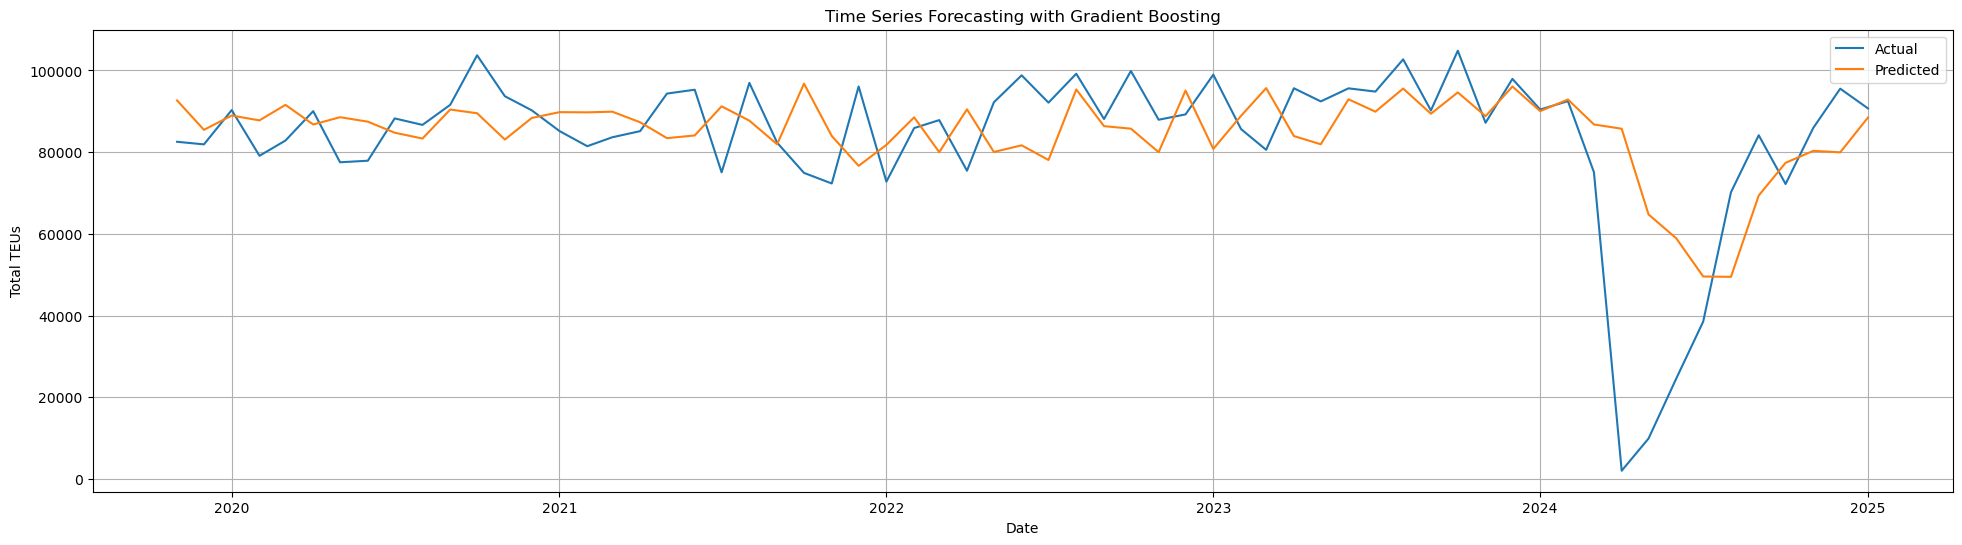

In [92]:
# 7. Visualize the Results
plt.figure(figsize=(24, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# 8. Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Lag_1: 0.4463
Lag_2: 0.1941
Lag_3: 0.1888
Lag_12: 0.1280
Lag_6: 0.0429


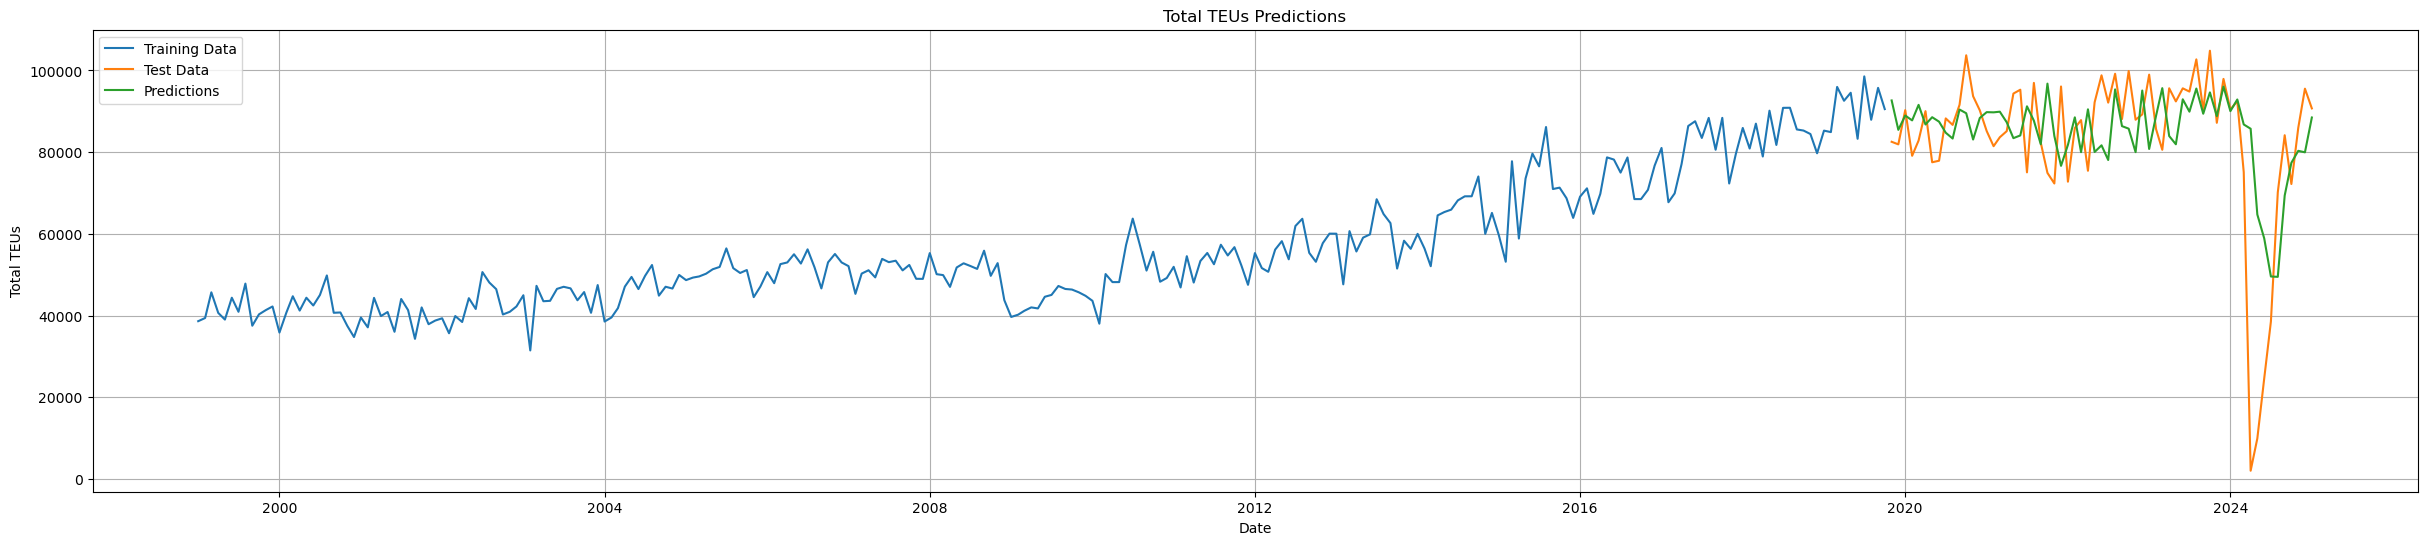

In [95]:
# 9. Plot the training data, test data and predictions on test set
plt.figure(figsize=(30, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()